# New stuff

More stuff with identifying motifs using CNN filters

In [1]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Flatten, \
    GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle

Using Theano backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# loading data
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

In [3]:
num_filters = [200,64,32]
filter_length = [6,6,6]

# max pooling model
model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))
model1.compile(loss='binary_crossentropy',
              optimizer='adam')


/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 33s - loss: 0.5947 - val_loss: 0.5732
Epoch 2/50
212035/212035 [==============================] - 32s - loss: 0.5700 - val_loss: 0.5654
Epoch 3/50
212035/212035 [==============================] - 33s - loss: 0.5634 - val_loss: 0.5603
Epoch 4/50
212035/212035 [==============================] - 32s - loss: 0.5587 - val_loss: 0.5575
Epoch 5/50
212035/212035 [==============================] - 33s - loss: 0.5561 - val_loss: 0.5554
Epoch 6/50
212035/212035 [==============================] - 33s - loss: 0.5540 - val_loss: 0.5533
Epoch 7/50
212035/212035 [==============================] - 33s - loss: 0.5521 - val_loss: 0.5523
Epoch 8/50
212035/212035 [==============================] - 33s - loss: 0.5506 - val_loss: 0.5514
Epoch 9/50
212035/212035 [==============================] - 34s - loss: 0.5495 - val_loss: 0.5531
Epoch 10/50
212035/212035 [==============================] - 33s - 

/usr/local/lib/python2.7/dist-packages/keras/models.py:603: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


In [5]:
predictions = model1.predict(X1_test)

In [6]:
r2_score(Y2_test, predictions)

0.4923860444000473

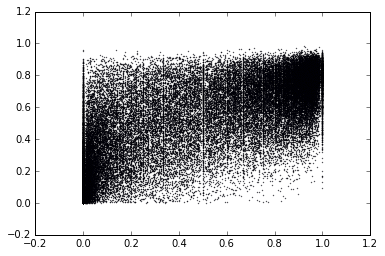

In [7]:
plt.scatter(Y2_test, predictions, s=0.1)

In [8]:
model1.save_weights('../data/2017-01-12.h5')
model_json = model1.to_json()
with open('../data/2017-01-12.json', 'w') as f:
    f.write(model_json)

In [9]:
import draw_logo
reload(draw_logo)

<module 'draw_logo' from '/home/yjzhang/Grad_School/research_notebooks/alternative_splicing_neural_nets/src/draw_logo.pyc'>

In [10]:
avg_filters = draw_logo.get_avg_filters(model1, X1_test)

In [11]:
avg_filters[0]

array([[ 0.329661  ,  0.13105322,  0.12331868,  0.4159671 ],
       [ 0.34454527,  0.2650116 ,  0.12367711,  0.26676602],
       [ 0.45614895,  0.12471467,  0.12448829,  0.29464808],
       [ 0.43434134,  0.13773133,  0.14118357,  0.28674376],
       [ 0.35561886,  0.12631817,  0.1460884 ,  0.37197457],
       [ 0.38319908,  0.17380068,  0.15953895,  0.2834613 ]])

[<Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>]

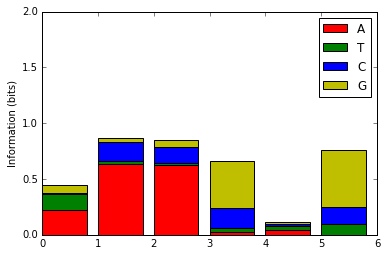

In [12]:
draw_logo.draw_logo(avg_filters[1], fixed_scale=True)

In [13]:
filter_weights = model1.layers[2].get_weights()[0]

In [14]:
filter_weights = np.reshape(filter_weights, len(filter_weights))

In [15]:
np.argmax(filter_weights)

54

[<Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>]

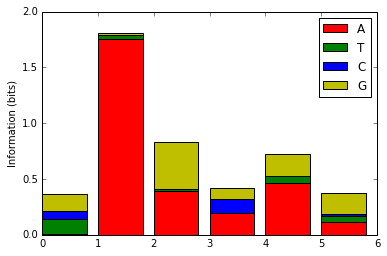

In [16]:
draw_logo.draw_logo(avg_filters[97], fixed_scale=True)

In [17]:
filter_weights[97]

-0.23496832

In [18]:
np.argmin(filter_weights)

55

[<Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>]

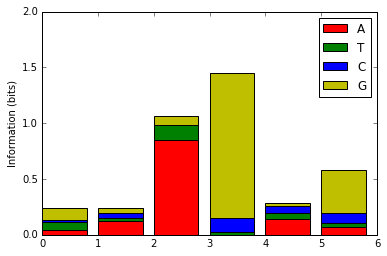

In [19]:
draw_logo.draw_logo(avg_filters[132], fixed_scale=True)

note: I feel like there's a bug somewhere... maybe the code to find the max logos has bugs? - like, positioning?

In [20]:
# find the 20 filters with the top information content, and plot them?
info = []
for i in range(200):
    info.append(6*2.0 - sum(draw_logo.entropy(avg_filters[i][j,:] for j in range(6))))
info_indices = sorted([(val, i) for i, val in enumerate(info)], reverse=True)
max_indices = [i[1] for i in info_indices[:20]]

## Maximum information content filters

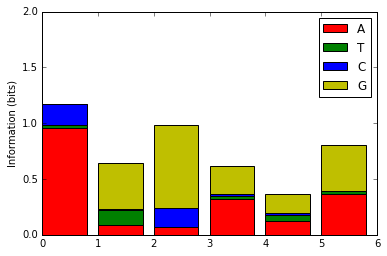

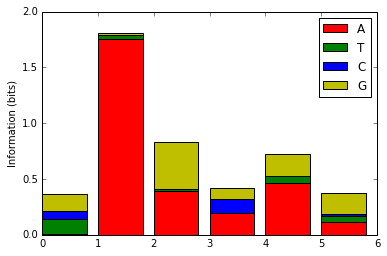

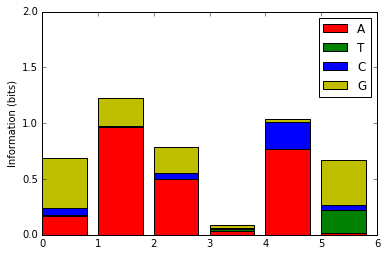

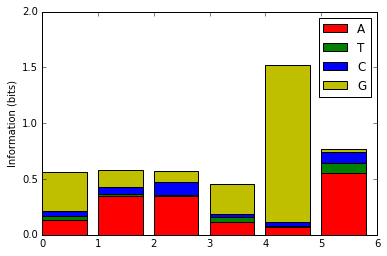

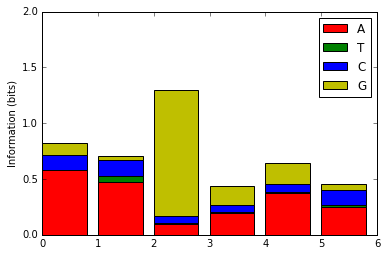

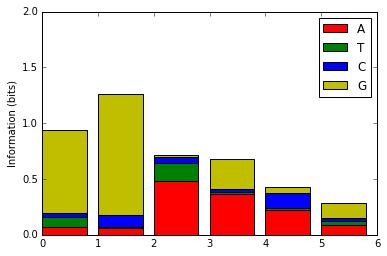

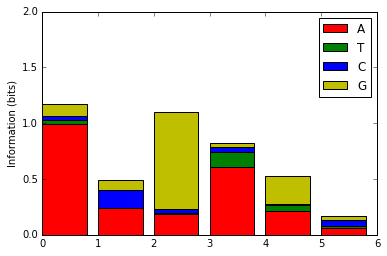

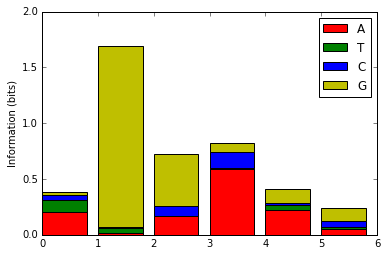

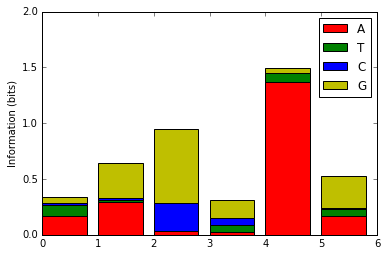

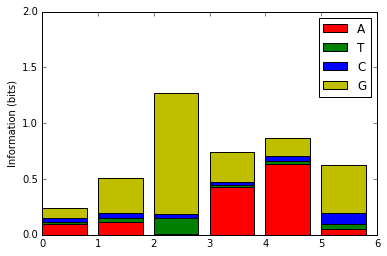

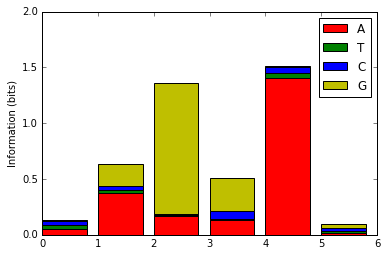

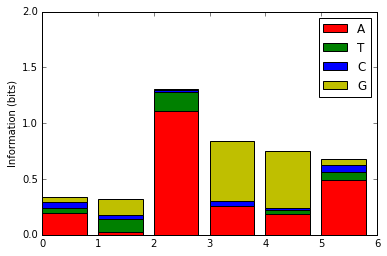

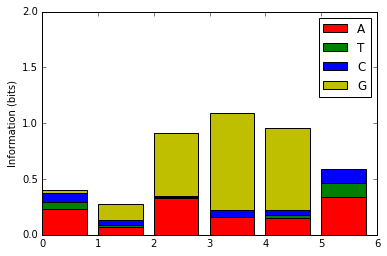

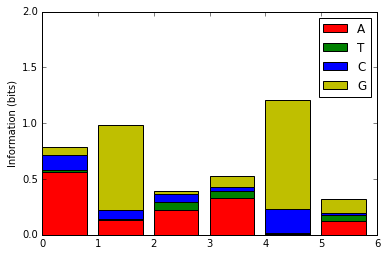

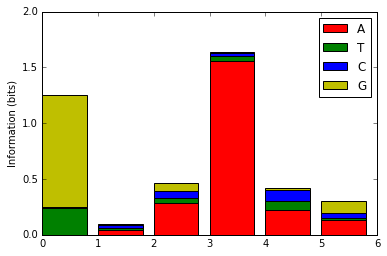

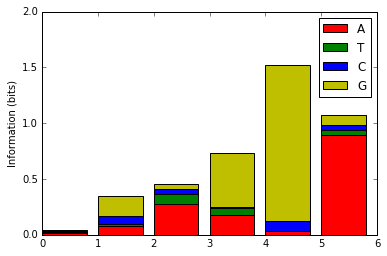

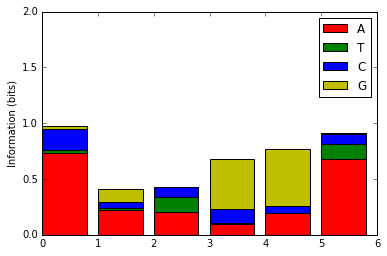

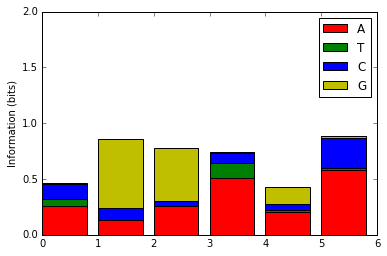

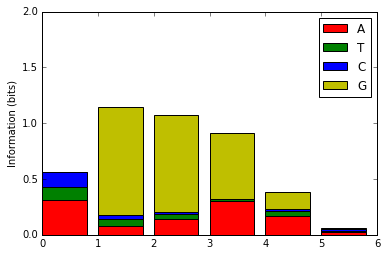

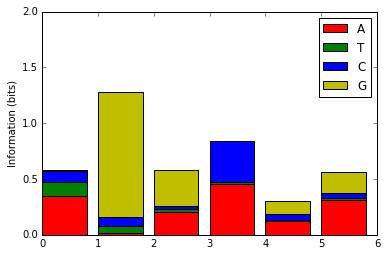

In [21]:
for index in max_indices:
    draw_logo.draw_logo(avg_filters[index], fixed_scale=True)

In [22]:
filter_weights[max_indices]

array([ 0.22790226, -0.23496832, -0.27439141,  0.14529683,  0.12240303,
       -0.32917479,  0.13360345,  0.19483511, -0.20479293, -0.21455194,
       -0.16762641,  0.15017904,  0.33383998,  0.20156226, -0.26222888,
        0.16052914,  0.26663449,  0.18532857,  0.28473702,  0.27152959], dtype=float32)

In [23]:
weights_sorted = sorted([(f, i) for i, f in enumerate(filter_weights)], reverse=True)
weights_max_indices = [i[1] for i in weights_sorted[:20]]

## Maximum weight filters

These should be the filters that have the most positive effect on alternative 5' exon inclusion.

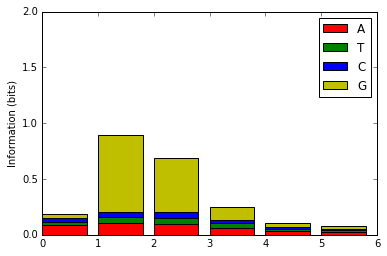

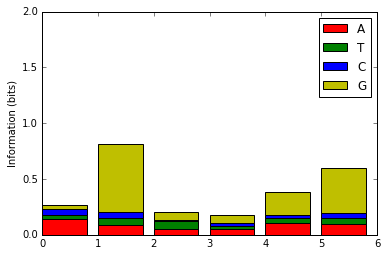

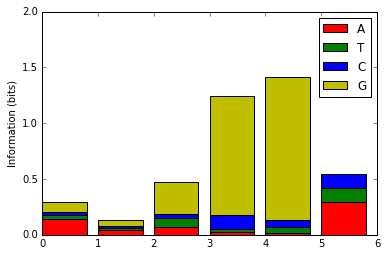

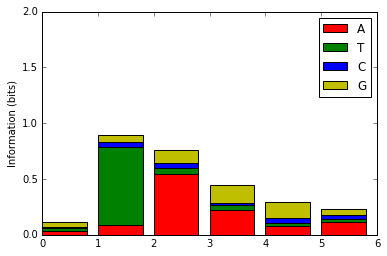

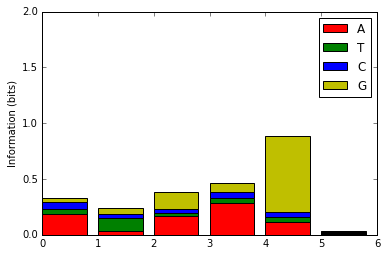

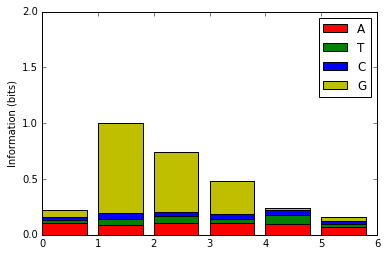

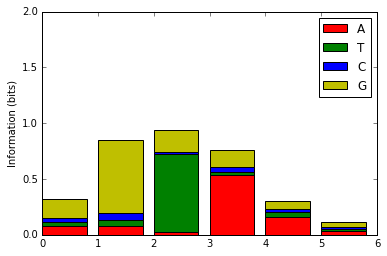

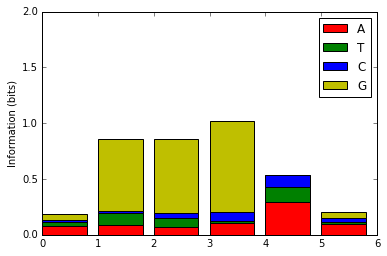

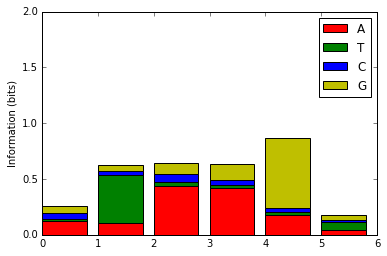

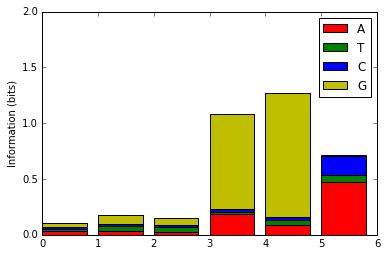

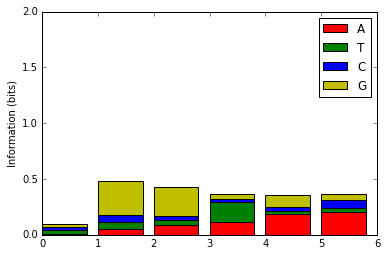

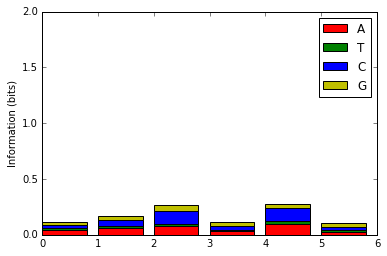

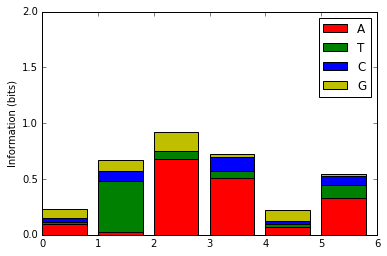

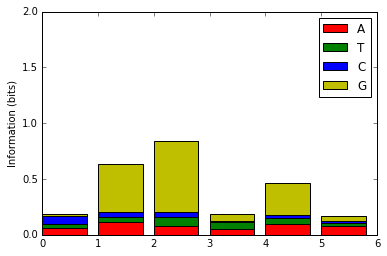

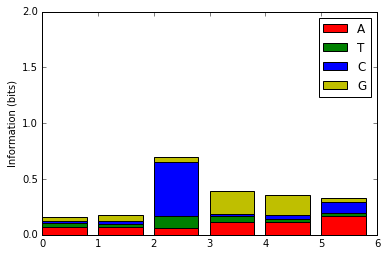

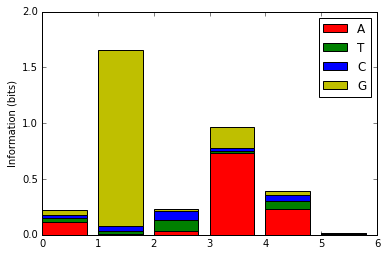

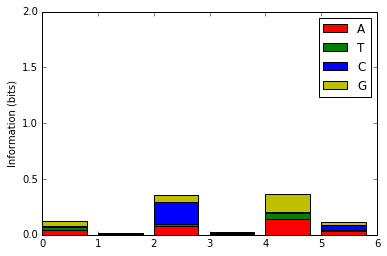

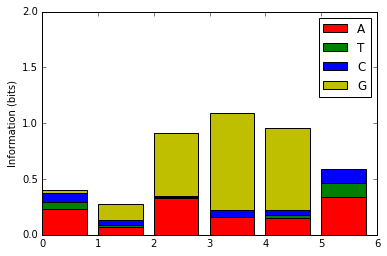

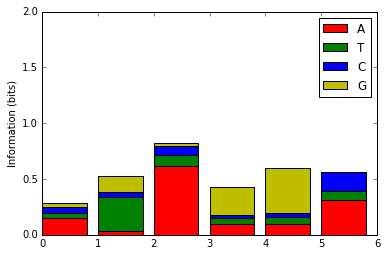

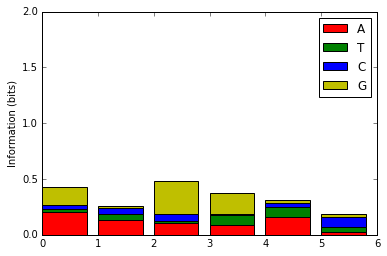

In [24]:
for index in weights_max_indices:
    draw_logo.draw_logo(avg_filters[index], fixed_scale=True)

## Most negative weight filters

These should be the filters that have the most negative effects on alternative 5' inclusion.

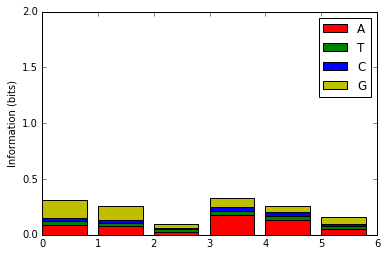

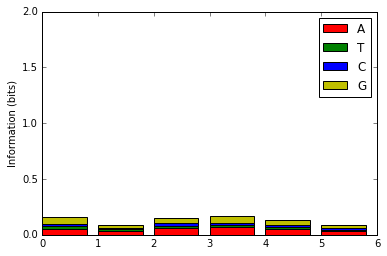

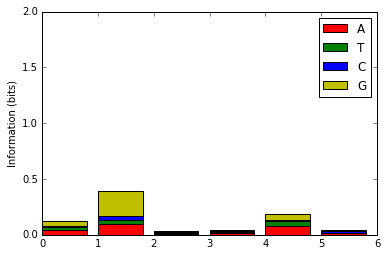

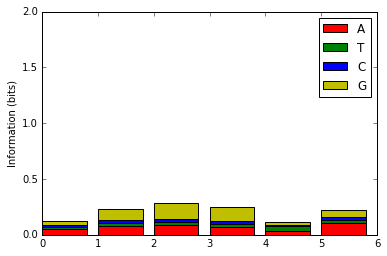

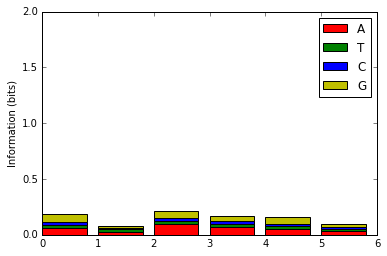

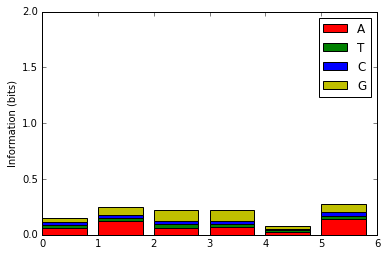

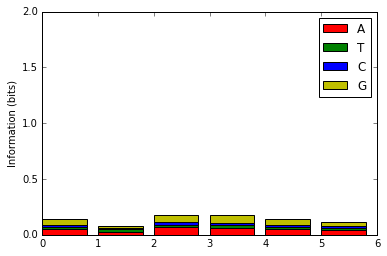

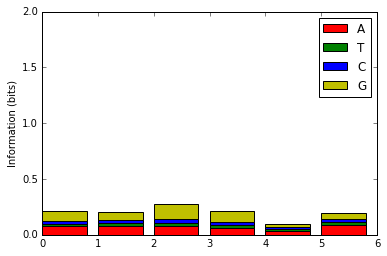

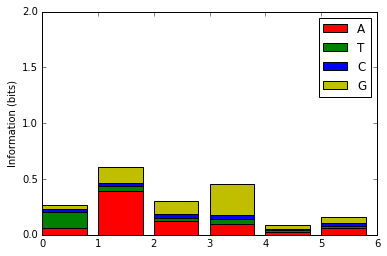

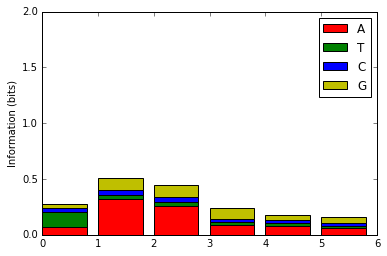

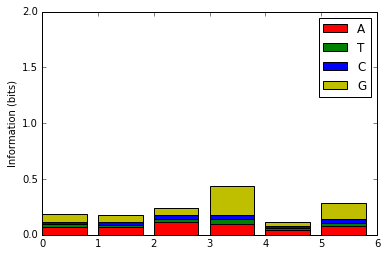

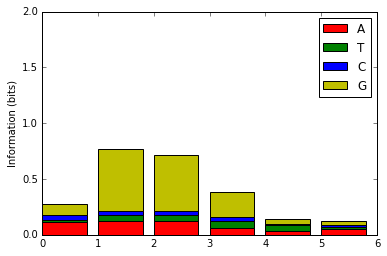

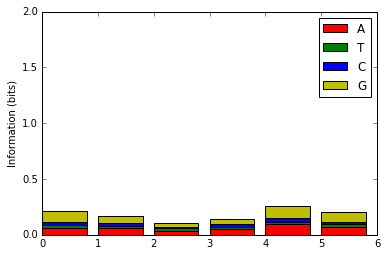

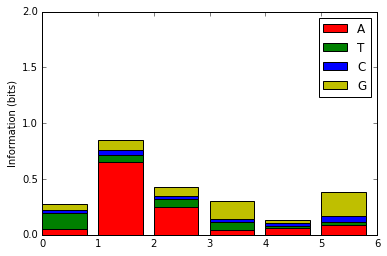

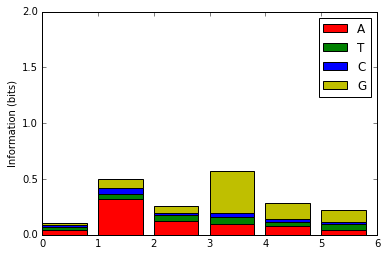

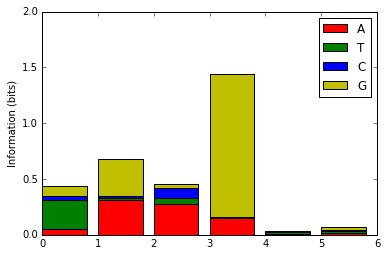

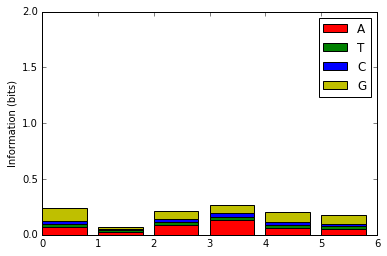

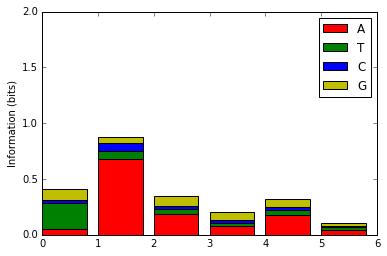

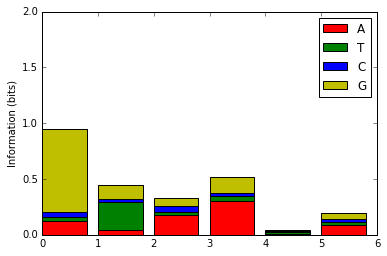

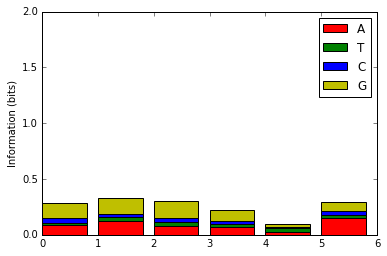

In [25]:
for val, index in list(reversed(weights_sorted))[:20]:
    draw_logo.draw_logo(avg_filters[index], fixed_scale=True)

In [26]:
# testing the get filters functions???

subseqs, layer_out = draw_logo.get_max_filters(model1, X1_test)

In [27]:
layer_out[:,196].sum()

58065.066

In [28]:
max_indices

[89,
 97,
 67,
 82,
 123,
 106,
 37,
 35,
 52,
 53,
 180,
 136,
 50,
 171,
 43,
 51,
 160,
 156,
 80,
 176]

In [29]:
list(reversed(weights_sorted))[:20]

[(-1.1743407, 55),
 (-1.1008457, 163),
 (-1.0478551, 70),
 (-0.97706759, 12),
 (-0.96101171, 0),
 (-0.9580996, 29),
 (-0.82427061, 154),
 (-0.72824323, 85),
 (-0.72152066, 34),
 (-0.59852403, 161),
 (-0.58859926, 125),
 (-0.55279022, 110),
 (-0.51953661, 96),
 (-0.51933044, 22),
 (-0.49677542, 143),
 (-0.49586073, 69),
 (-0.4923358, 59),
 (-0.49083087, 15),
 (-0.47782427, 92),
 (-0.46156698, 79)]

TODO: try another random initialization on the same data set and see if we get the same filters.

In [31]:
np.save('../data/2017-01-12-filters', avg_filters)